## Derivatives by finite difference

Section 5.4, 5.5.

We can approximate a derivative using formulas of the form

$$f'(x) = \frac{1}{h}\sum_{k=-m}^na_kf(x+kh)$$

where $a_k$ are called weights. Formulas for unevenly spaced points ($x+\Delta x_k$) are possible, but less commonly used.

The most common formulas are the forward,
$$f'(x) \approx \frac{f(x+h)-f(x)}{h}$$
backward, 
$$f'(x) \approx \frac{f(x)-f(x-h)}{h}$$
and centred differences:
$$f'(x) \approx \frac{f(x+h)-f(x-h)}{2h}$$

Tables 4.5.1 and 4.5.2 in the text list other sets of weights. The weights can be derived from interpolation formulas. Function 5.4.7 (Fornberg's algorithm) is another route to obtaining these coefficients, which works on unequally spaced knots (interpolation points) as well.

Truncation (of powerseries) error in the first two is $O(h^2)$. Use Taylor's theorem on $f(x+h)$; see Example 5.5.4. A problem arises if $h$ is too small; loss of precision from subtracting nearly equal quantities grows as $h$ gets smaller.

## Finite differences

Define and test a few finite difference formulas.

In [94]:
using Plots

In [95]:
forward_diff(f, x, h = sqrt(eps(x))) = (f(x+h)-f(x))/h
backward_diff(f, x, h = sqrt(eps(x))) = (f(x)-f(x-h))/h
centered_diff(f, x, h = sqrt(eps(x))) = (f(x+h)-f(x-h))/(2*h)

centered_diff (generic function with 2 methods)

In [96]:
f2(x) = 3*x^3+2*x - 1
df(x) = 9x^2+2
@show df(2.0)
@show forward_diff(f2, 2.0)
@show backward_diff(f2, 2.0)
@show centered_diff(f2, 2.0)

df(2.0) = 38.0
forward_diff(f2, 2.0) = 38.00000069835685
backward_diff(f2, 2.0) = 37.99999968683249
centered_diff(f2, 2.0) = 38.00000019259467


38.00000019259467

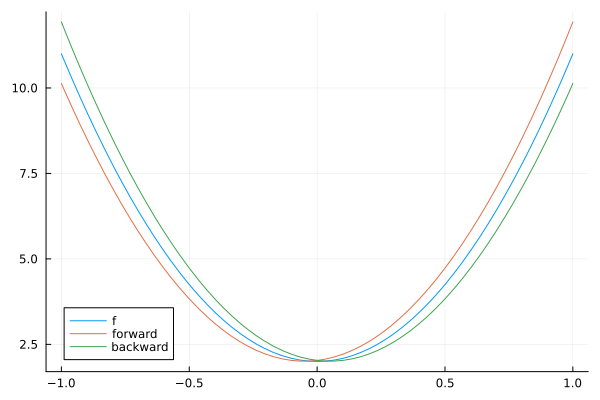

In [97]:
plot(df, -1, 1, label = "f")
plot!(x -> forward_diff(f2, x, 0.1), -1, 1, label = "forward")
plot!(x -> backward_diff(f2, x, 0.1), -1, 1, label = "backward")

Error as a function of h.

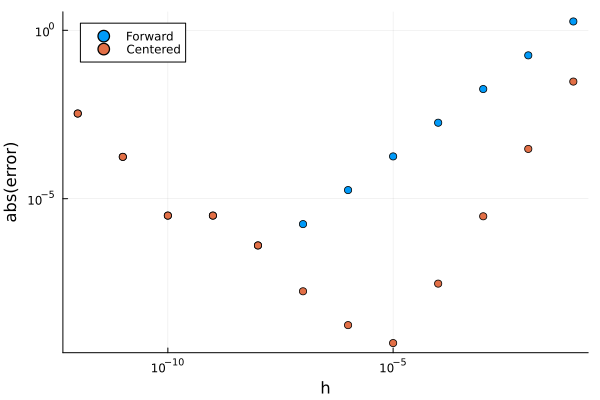

In [98]:
h = 10.0 .^ -(1:12)
error1 = df(2.0) .- forward_diff.(f2, 2.0, h);
error2 = df(2.0) .- centered_diff.(f2, 2.0, h);
scatter(h, abs.(error1), xlabel = "h", ylabel = "abs(error)", label = "Forward")
scatter!(h, abs.(error2), label = "Centered", xscale = :log10, yscale = :log10, legend = :topleft)

## Finding finite difference formulas

The forward difference formula can be found from Taylor's approximation:

$$f(x+h) = f(x) + hf'(x) + h^2f''(\xi).$$

Solve for $f'(x)$ to get 

$$f'(x) = \frac{f(x+h)-f(x)}{h} - h f''(\xi).$$

For finite difference formulas evaluated at several values of $x$, it's better to start with Lagrange interpolating polynomials.

The idea is simple: 

* find the interpolating formula for $f$ evaluated at $x_0$ and several near by points $x_0+kh$.
* differentiate the polynomial with respect to $x$ as many times as you want
* evaluate the polynomial at $x_0$ to get the finite difference approximation to the corresponding derivative.

Unfortunately I've not made this approach work in Julia -- I need to learn more about its symbolic computation system.

In [99]:
using Polynomials, SpecialPolynomials

In [100]:
L1 = fit(Lagrange, [-2, -1, 0, 1, 2], [1,2,3,4,5])

Lagrange(1⋅P_0(x) + 2⋅P_1(x) + 3⋅P_2(x) + 4⋅P_3(x) + 5⋅P_4(x))

In [101]:
P1 = convert(Polynomial, L1)

Polynomial(3.0 + 0.9999999999999999*x - 2.7755575615628914e-16*x^2 + 5.551115123125783e-17*x^4)

In [102]:
L1(0.5), P1(0.5)

(3.5, 3.5)

In [103]:
derivative(P1, 1)

Polynomial(0.9999999999999999 - 5.551115123125783e-16*x + 2.220446049250313e-16*x^3)

In [104]:
using Symbolics

In [105]:
@variables x0 h x f[1:3]

4-element Vector{Any}:
 x0
  h
  x
   f[1:3]

In [106]:
function lagrange_help(xs, k)
    ks = collect([0:k-1; k+1:length(xs)-1] .+ 1) # k is 0 indexed
    x -> prod(x - t for t in xs[ks])  
end
lagrange_basis(xs, k) = x -> lagrange_help(xs, k)(x) / lagrange_help(xs, k)(xs[k+1]);
p(xs, ys) = x -> sum( ys[k]*lagrange_basis(xs, k-1)(x) for k in 1:length(xs) );

In [91]:
x1 = [x0, x0+h, x0+2*h]
@show lagrange_help(x1, 1)(x)
p(x1, f)(x) # not what I want; I want f to be a function evaluated at x_k

(lagrange_help(x1, 1))(x) = (x - x0)*(x - x0 - 2h)


((x - x0)*(x - h - x0)*f[3]) / (2(h^2)) + ((x - x0 - 2h)*(x - h - x0)*f[1]) / (2(h^2)) + (-(x - x0)*(x - x0 - 2h)*f[2]) / (h^2)

In [89]:
p(x1, sin.(x1))(x) # for example, this works...but I don't know how to differentiate it...

((x - x0)*(x - h - x0)*sin(x0 + 2h)) / (2(h^2)) + ((x - x0 - 2h)*(x - h - x0)*sin(x0)) / (2(h^2)) + (-(x - x0)*(x - x0 - 2h)*sin(h + x0)) / (h^2)

Next steps: compute the Lagrage polynomial for $f$ at equally spaced points, differentiate, and evaluate at $x=x_0$. I couldn't make this symbolic calcuation work in Julia. Switch to Mathematica or Maple.


### Fornberg's algorithm

Using Lagrange polynomials for interpolation and differentiation. Derived in the [original publication](https://web.njit.edu/~jiang/math712/fornberg.pdf) from 1988. Here is [a Julia implementation](https://github.com/bekaiser/Fornberg/blob/master/Lagrange_poly_derivatives.jl) that doesn't use recursion.

In [1]:
"""
    fdweights(t,m)

Compute weights for the `m`th derivative of a function at zero using
values at the nodes in vector `t`.
"""
function fdweights(t,m)
# This is a compact implementation, not an efficient one.
    # Recursion for one weight. 
    function weight(t,m,r,k)
        # Inputs
        #   t: vector of nodes 
        #   m: order of derivative sought 
        #   r: number of nodes to use from t 
        #   k: index of node whose weight is found

        if (m<0) || (m>r)        # undefined coeffs must be zero
            c = 0
        elseif (m==0) && (r==0)  # base case of one-point interpolation
            c = 1
        else                     # generic recursion
            if k<r
                c = (t[r+1]*weight(t,m,r-1,k) -
                    m*weight(t,m-1,r-1,k))/(t[r+1]-t[k+1])
            else
                numer = r > 1 ? prod(t[r]-x for x in t[1:r-1]) : 1
                denom = r > 0 ? prod(t[r+1]-x for x in t[1:r]) : 1
                β = numer/denom
                c = β*(m*weight(t,m-1,r-1,r-1) - t[r]*weight(t,m,r-1,r-1))
            end
        end
        return c
    end
    r = length(t)-1
    w = zeros(size(t))
    return [ weight(t,m,r,k) for k=0:r ]
end;

In [2]:
t = [ 0.25,0.45,0.55,0.75 ]   # nodes chosen at random; symmetry and close spacing helps
f = x -> sin(exp(x))
dfdx = x -> cos(exp(x))*exp(x)
@show exact_value = dfdx(0.5)
@show w = fdweights(t.-0.5,1)
@show fd_value = w' * f.(t);

exact_value = dfdx(0.5) = -0.12834652741859814
w = fdweights(t .- 0.5, 1) = [0.08333333333333291, -10.416666666666664, 10.416666666666666, -0.08333333333333387]
fd_value = w' * f.(t) = -0.12840342495850937


Using rational numbers we can obtain the coefficients in the tables.

In [3]:
@show fdweights(Rational.(-1:1),1);
@show fdweights(Rational.(-2:2),1);
@show fdweights(Rational.(0:4),1);

fdweights(Rational.(-1:1), 1) = Rational{Int64}[-1//2, 0//1, 1//2]
fdweights(Rational.(-2:2), 1) = Rational{Int64}[1//12, -2//3, 0//1, 2//3, -1//12]
fdweights(Rational.(0:4), 1) = Rational{Int64}[-25//12, 4//1, -3//1, 4//3, -1//4]


Second derivatives

In [4]:
@show fdweights(Rational.(-1:1),2);
@show fdweights(Rational.(-2:2),2);
@show fdweights(Rational.(0:4),2);

fdweights(Rational.(-1:1), 2) = Rational{Int64}[1//1, -2//1, 1//1]
fdweights(Rational.(-2:2), 2) = Rational{Int64}[-1//12, 4//3, -5//2, 4//3, -1//12]
fdweights(Rational.(0:4), 2) = Rational{Int64}[35//12, -26//3, 19//2, -14//3, 11//12]
